Artificial Neural Networks

Implementar una Red Neuronal Artificial Multiclase para la clasificación de imágenes de dígitos  del 0 al 9 escritos a mano (handwriting digit recognition).


In [302]:
!pip install --upgrade gdown

In [303]:
!gdown --id 1x0JbCKDCGtynM6GnunAOdDYlyt7dI0B- -O mnist.txt

C:\Users\ruben\anaconda3\Lib\site-packages\gdown\__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1x0JbCKDCGtynM6GnunAOdDYlyt7dI0B-
To: E:\UADY\2\CNN\Lab4\machine_learning\mnist.txt

  0%|          | 0.00/9.13M [00:00<?, ?B/s]
  6%|5         | 524k/9.13M [00:00<00:03, 2.37MB/s]
 17%|#7        | 1.57M/9.13M [00:00<00:01, 5.16MB/s]
 29%|##8       | 2.62M/9.13M [00:00<00:01, 6.49MB/s]
 46%|####5     | 4.19M/9.13M [00:00<00:00, 8.32MB/s]
 63%|######3   | 5.77M/9.13M [00:00<00:00, 9.53MB/s]
 80%|########  | 7.34M/9.13M [00:00<00:00, 10.3MB/s]
 98%|#########7| 8.91M/9.13M [00:01<00:00, 10.7MB/s]
100%|##########| 9.13M/9.13M [00:01<00:00, 8.95MB/s]


In [304]:
import numpy as np
import matplotlib.pyplot as plt

 la base de datos consiste en 785 elementos separados por comas, donde los
primeros 784 valores identifican los pixeles de la imágen del dígito, y el último valor del renglón
indica la clase a la que pertenece

In [305]:
import numpy as np

def load_data(file_path):
    with open(file_path) as file:
        data = [line.strip().split(" ") for line in file]
        features = [np.asarray(data_point[:784], dtype=float) for data_point in data] # pixeles de la imágen
        labels = [float(data_point[-1]) for data_point in data]                       # clase a la que pertenece

    return features, labels

In [363]:
def visualize_image(images, labels, n):
    if n >= len(images):
        print("El índice n está fuera del rango.")
        return
    image = images[n].reshape(28, 28)  # reconstruye la imagen en una matriz de 28x28
    label = int(labels[n])

    plt.imshow(image, cmap='gray')
    plt.title(f"Imagen del dígito: {label} índice:{n}")
    plt.axis('off')
    plt.show()

In [307]:
# Cargar los datos
file_path = "mnist.txt"
images, labels = load_data(file_path)
print(len(images))
print(len(labels))

5000
5000


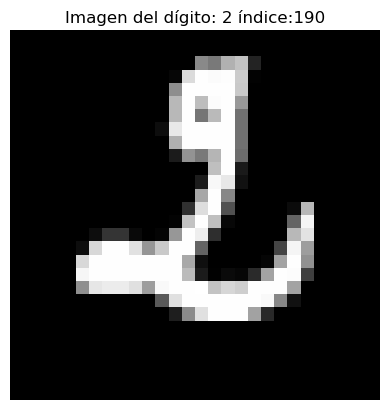

In [308]:
# Visualizar la imagen en la posición n
import random
n = random.randint(0, 5000)
visualize_image(images, labels, n)

In [309]:
class CrossEntropy:
    def __init__(self, epsilon=1e-10):# Valor pequeño para evitar errores matemáticos
        self.epsilon = epsilon

    def __call__(self, P, Y): # Función de costo de entropía cruzada
        return -np.mean(Y * np.log(P + self.epsilon) + (1 - Y) * np.log(1 - P + self.epsilon))

    def derivative(self, P, Y):
        return -(Y / (P + self.epsilon)) + (1 - Y) / (1 - P + self.epsilon)

In [310]:
class Layer:
    def __init__(self, connexions, neurons):
        self.bias = np.random.rand(1, neurons) * 2 - 1
        self.weights = np.random.rand(connexions, neurons) * 2 - 1
        
class Sigmoid: # Sigmoid Activation function
    def __call__(self, x):
        return 1 / (1 + np.e ** (-x))

    def derivative(self, x):
        return x * (1 - x)

In [311]:
!pip install tensorflow
from tensorflow.keras.utils import to_categorical

In [322]:
# Class to instatiate the model
class neural_network():
    def __init__(self, layers):
        self.layers = layers
        self.cost_function = CrossEntropy()

    def _forward_propagation(self, input_data):
        activation = Sigmoid()
        fwrd_result = [(None, input_data)] 
        for l, layer in enumerate(self.layers):
            z = fwrd_result[-1][1] @ layer.weights + layer.bias
            a = activation(z)
            fwrd_result.append((z, a))
        return fwrd_result

    def _backward_propagation(self, labels, fwrd_pass): 
        activation = Sigmoid()
        gradients = list()
        for layer_index, layer in reversed(list(enumerate(self.layers))): # Iteramos las capas de atrás hacia adelante
            current_weight = fwrd_pass[layer_index+1][1]
            if not gradients: #  capa de salida  derivada de la función de coste
                gradients.insert(0, self.cost_function.derivative(current_weight, labels) * activation.derivative(current_weight)) 
            else:
                previous_layer_weights = self.layers[layer_index + 1].weights.T
                gradients.insert(0, gradients[0] @ previous_layer_weights * activation.derivative(current_weight))
        return gradients

    def train(self, X, Y, learning_rate, epochs):
        history = list()
        print_interval = epochs // 5  # Imprimir la pérdida cada 20% del entrenamiento
        
        for epoch  in tqdm(range(epochs)):
            # calcular (a,z) para cada capa y almacenarlos en una lista
            forward_pass = self._forward_propagation(X/255) 
            
            # Calcular la pérdida para seguir el rendimiento del modelo durante el entrenamiento
            loss = self.cost_function(forward_pass[-1][1], to_categorical(Y)) 
            
            # calcular las derivadas de la función de coste con respecto a los pesos y sesgos (gradientes)
            gradients = self._backward_propagation(to_categorical(Y), forward_pass) 
    
            # Actualización de los pesos y sesgos 
            for layer_index, _ in reversed(list(enumerate(self.layers))): 
                layer = self.layers[layer_index]
                layer.bias -= learning_rate * np.mean(gradients[layer_index], axis=0, keepdims=True)
                layer.weights -= learning_rate * forward_pass[layer_index][1].T @ gradients[layer_index]
    
            history.append(loss)
            
            # Imprimir la pérdida cada 20% de las épocas
            if (epoch + 1) % print_interval == 0:
                print(f'Pérdida después de {((epoch+1)/epochs) * 100:.0f}% de las épocas: {loss}')
      
        return history

    def predict(self, X):
        # Realizamos la propagación hacia adelante
        forward_pass = self._forward_propagation(X)
        
        # Obtenemos las activaciones de la última capa
        last_layer_activations = forward_pass[-1][1]
        
        # Para cada conjunto de activaciones, seleccionamos el índice con la mayor activación
        predictions = [np.argmax(activations) for activations in last_layer_activations]
        
        return predictions

In [313]:
from sklearn.model_selection import train_test_split

In [314]:
from tqdm import tqdm

In [315]:
X_train, X_test, Y_train, Y_test = train_test_split(np.asarray(images[:1000]), labels[:1000], test_size=0.1, shuffle=True)

In [339]:
model = neural_network(
    [
        Layer(784, 300),
        Layer(300, 100),
        Layer(100, 10)
    ]
)

In [340]:
epochs = 500
leraning_rate = 0.001
history = model.train(X_train, Y_train, leraning_rate, epochs)

 21%|██        | 104/500 [00:03<00:12, 31.91it/s]

Pérdida después de 20% de las épocas: 0.06357911374289263


 41%|████      | 204/500 [00:06<00:08, 33.13it/s]

Pérdida después de 40% de las épocas: 0.026869339029065003


 61%|██████    | 304/500 [00:09<00:05, 33.01it/s]

Pérdida después de 60% de las épocas: 0.014422900836331845


 81%|████████  | 404/500 [00:12<00:03, 31.99it/s]

Pérdida después de 80% de las épocas: 0.009047347293779508


100%|██████████| 500/500 [00:15<00:00, 32.58it/s]

Pérdida después de 100% de las épocas: 0.006390944745769875


In [369]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir las neuronas de entrada
for i in range(784):
    G.add_node(f"entrada_{i}")

# Añadir las neuronas de la capa oculta
for i in range(300):
    G.add_node(f"capa_oculta_{i}")

# Añadir las neuronas de salida
for i in range(10):
    G.add_node(f"salida_{i}")

# Añadir las aristas entre las neuronas
for i in range(784):
    for j in range(300):
        G.add_edge(f"entrada_{i}", f"capa_oculta_{j}")

for i in range(300):
    for j in range(10):
        G.add_edge(f"capa_oculta_{i}", f"salida_{j}")

# Dibujar el grafo
nx.draw_graphviz(G, prog="dot", node_attr={"shape": "circle", "fixedsize": "true", "width": "0.5"}, font_size=10)
plt.show()

AttributeError: module 'networkx' has no attribute 'draw_graphviz'

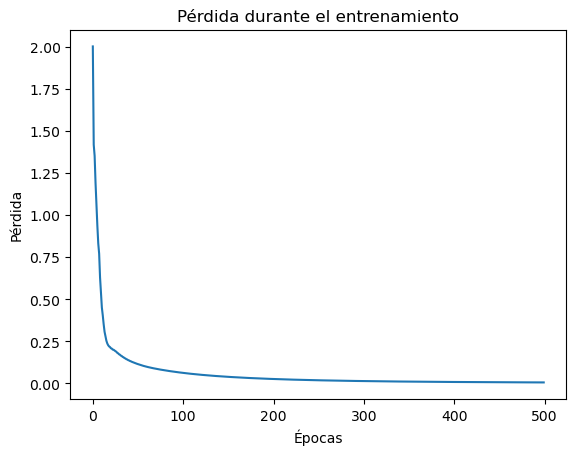

In [342]:
plt.plot(history)
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.show()

In [347]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [348]:
# Realizamos las predicciones para los conjuntos de entrenamiento y prueba
predicciones_entrenamiento = model.predict(X_train)
predicciones_prueba = model.predict(X_test)

# Calculamos el número de predicciones correctas
correctas_entrenamiento = sum(pred == y for pred, y in zip(predicciones_entrenamiento, Y_train))
correctas_prueba = sum(pred == y for pred, y in zip(predicciones_prueba, Y_test))

# Calculamos la precisión como un porcentaje con dos cifras decimales
precision_entrenamiento = round((correctas_entrenamiento / len(Y_train)) * 100, 2)
precision_prueba = round((correctas_prueba / len(Y_test)) * 100, 2)

print(f'Precisión en el conjunto de entrenamiento: {precision_entrenamiento}%')
print(f'Precisión en el conjunto de prueba: {precision_prueba}%')

Precisión en el conjunto de entrenamiento: 99.78%
Precisión en el conjunto de prueba: 87.0%


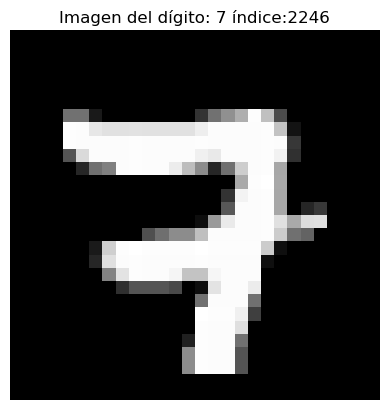

Predicción: 7


In [368]:
# elegir un índice aleatorio y prededir la imagen con el modelo entrenado
import random
n = random.randint(0, 5000)
visualize_image(images, labels, n)

randon_image = images[n]
# Realizamos la predicción
prediction = model.predict(randon_image)
print(f'Predicción: {prediction[0]}')